In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import csv
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, optimizers, utils, initializers
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras import layers, optimizers
from kerastuner.tuners import RandomSearch, Hyperband
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from tensorflow.keras.models import load_model
from IPython.display import Image


# Localisation - 3 classes -1 Server

In this notebook, we are doing localisation on BLE packets, meaning that we are trying to locate an emitter based on the traffic it emits. We are using data from Scenario 5, in which the emitter and the server are still, using 3 nRF52 dev kits used as BLE advertising devices, 4 USRPs used as receivers. We are using raw IQ data as input. 
We are using data solely from Scene 35, Scene 36 and Scene 37 in which only one emitter is advertising. In Scene 35 it is a nRF52 apuN2, in Scene 36 it is a nRF52 apuP22, and in Scene 37 it is a nRF52 apuQ2. This means that we now have 3 classes, considering each scene (i.e. each location) as a class. We are using data solely from one server, Server 11, and only one packet length, 1520, since they are the most represented in the dataset.

| Scene | 35 | 36 | 37 |
| --- | --- | --- | --- |
| Server 9 | X | X | X |
| --- | --- | --- | --- |
| Server 11 | X | X | X |
| --- | --- | --- | --- |
| Server 12 | X | X | X |
| --- | --- | --- | --- |
| Server 15 | X | X | X |
| --- | --- | --- | --- |
| nRF52 apuN2 | X |   |   |
| --- | --- | --- | --- |
| nRF52 apuP22 |   | X |   |
| --- | --- | --- | --- |
| nRF52 apuQ2 |   |   | X |
| --- | --- | --- | --- |
| Duration (s) | 60 | 60 | 60 |
| --- | --- | --- | --- |
| Number of executions | 3 | 2 | 3 |

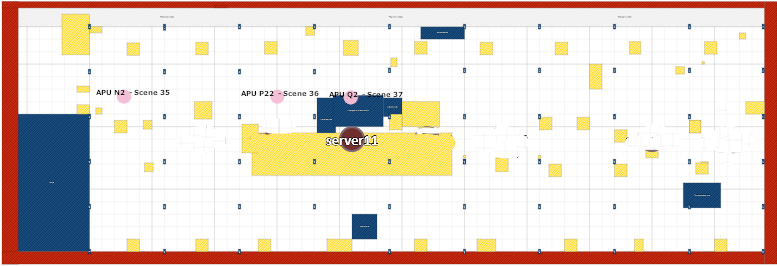

In [3]:
Image("../img/1server_353637.PNG")

In [2]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:

d_five=pd.read_csv('../data/processed/scenario5_scene35.csv')
d_five['X']=5200
d_five['Y']=740
d_six=pd.read_csv('../data/processed/scenario5_scene36.csv')
d_six['X']=4000
d_six['Y']=740
d_seven=pd.read_csv('../data/processed/scenario5_scene37.csv')
d_seven['X']=3400
d_seven['Y']=740


idata = pd.concat([d_five, d_six, d_seven], ignore_index=True)


In [4]:
print(idata['Len Packet'].value_counts())

idata=idata[idata['Len Packet']==1520]
print(len(idata.index))

idata=idata[idata['Server_id']==11]

1520    5976640
1880     246280
1360     161840
880       28160
1320      17160
1760       3520
Name: Len Packet, dtype: int64
5976640


In [5]:
print(idata['X'].value_counts())
print(idata['Y'].value_counts())

5200    851200
4000    457520
3400    346560
Name: X, dtype: int64
740    1655280
Name: Y, dtype: int64


## Creating Neural Network input

We are creating input for the CNN: X is composed of 1520 IQ samples, and Y is the scene number, meaning the emitter used in each of these scenes. The input data, i.e. the IQ data are normalized.

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
idata[['real','im']]=scaler.fit_transform(idata[['real','im']].values)

### Use the whole packet as input

In this case, we use the whole packet (i.e. 1520 IQ samples as input). Thus, the input has the following shape (1520,2).

In [7]:
def input_whole_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: scene = robot_node
    X=list()
    Y=list()

    pkt_len=1520

    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+pkt_len]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape(pkt_len,2)
            X.append(x)
            Y.append(idata.iloc[i]['X'])  #in each scene a different emitter is used ~ robot_node in that case
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)

    input_shape=(pkt_len,2)
    batch_size=10
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

### Use only part of the packet as input

In this case, we use only a fraction f of each packet, always of the same length and at the same position in the packet. We take only one fraction per packet. Thus, the input has the following shape (f, 2).

In [8]:
def input_part_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()
    pkt_len=1520
    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+200]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape((200),2)
            X.append(x)
            Y.append(idata.iloc[i]['X'])  #in each scene a different emitter is used ~ robot_node in that case
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)
    
    batch_size=10
    input_shape=(200,2)
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

### Creates overlapping slices of each packet and gather them into a batch

In this cas, we use a fraction f (called slice) of a packet for each input, but the slices are overlapping. This means that there are several slices corresponding to the same packet. Moreover, since the slices are overlapping, it means that the same IQ samples can be found in several slices.

In [9]:
def input_slices_pkt(idata, len_slice, shift):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()
    pkt_len=1520
    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+pkt_len]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape((pkt_len),2)
            #creates slices of the packet and gather them in a single batch
            x=tf.data.Dataset.from_tensor_slices(x)
            x = x.window(len_slice, shift, 1, True)
            count=0
            for window in x:
                X.append(list(window.as_numpy_iterator()))
                count=count+1
                
                Y.append(idata.iloc[i]['X'])  
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)

    input_shape=X[0].shape
    batch_size=count
    
    print("Il y a "+str(len(Y))+" échantillons")
    print(X.shape)
    print(Y.shape)
    
    return (X, Y, input_shape, batch_size)

In [10]:
def balance_classes(X,Y):
    unique_elements, counts_elements = np.unique(Y, return_counts=True)


    #balance classes
    min_samples=min(counts_elements)


    thirty_five_index=np.where(Y == 5200)
    thirty_five_index=thirty_five_index[0][:min_samples]
    X_thirty_five=X[thirty_five_index]
    Y_thirty_five=Y[thirty_five_index]

    thirty_six_index=np.where(Y == 4000)
    thirty_six_index=thirty_six_index[0][:min_samples]
    X_thirty_six=X[thirty_six_index]
    Y_thirty_six=Y[thirty_six_index]

    thirty_seven_index=np.where(Y == 3400)
    thirty_seven_index=thirty_seven_index[0][:min_samples]
    X_thirty_seven=X[thirty_seven_index]
    Y_thirty_seven=Y[thirty_seven_index]

    X=np.concatenate((X_thirty_five, X_thirty_six, X_thirty_seven))
    Y=np.concatenate((Y_thirty_five, Y_thirty_six, Y_thirty_seven))

    print(np.unique(Y, return_counts=True))
    return (X,Y)

In [11]:
def name_classes(Y):
    Y_change=list()

    #35:0, 36:1 37:2
    for i in Y:
        if i==5200:
            Y_change.append(0)
        elif i==4000:
            Y_change.append(1)
        elif i==3400:
            Y_change.append(2)

    Y_change=np.array(Y_change)
    
    return Y_change

In [12]:
def data_preparation_nn(idata, type_input, len_slice, shift):
    if type_input=='whole':
        X,Y,input_shape,batch_size=input_whole_pkt(idata)
    elif type_input=='part':
        X,Y,input_shape,batch_size=input_part_pkt(idata)
    elif type_input=='slice':
        X,Y,input_shape,batch_size=input_slices_pkt(idata, len_slice, shift)
    X,Y=balance_classes(X,Y)
    
        
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=54)
    return(X_train, X_test, y_train, y_test, input_shape, batch_size)

## Performances

We use the following functions to estimate the performances of the various models we will be testing.

This function plots the accuracy (i.e. the number of correctly classified elements over the total number of elements) during training, as well as the validation accuracy (i.e. the accuracy of the model on the validation set).

In [13]:
def plot_accuracy(history):
    i = np.arange(len(history.history['loss']))
    plt.xlabel('Step')
    plt.ylabel('Rmse')
    plt.plot(i, history.history['root_mean_squared_error'], label='rmse')
    plt.plot(i, history.history['val_root_mean_squared_error'], label='val_rmse')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

This function gathers the metrics we will need to estimate the performances of a model on the train set. The confusion matrix allows us to visualize how many elements of each class have been accurately classified, how many have been wrongly classified and in this case with which other class they have been getting mixed up.
We also have the f1-score for each class, which quantifies the trade-off between the precision (i.e. how many elements classified as a given class are actually part of this class) and the recall (i.e. how many elements actually part of a given class have been classified as such). We alse compute the global f1-score, which is a weighted mean of the f1-score for each class. Finally, we can see the global accuracy.

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def test_metrics(model, y_test, X_test):
    predictions= model.predict(X_test)
   

    mae=mean_absolute_error(y_test, predictions)
    print("Mean Absolute Error")
    print(mae)

    rmse=mean_squared_error(y_test, predictions, squared=False)
    print("Root Mean Squared Error")
    print(rmse)
    
    print("Axis X")
    fig, ax = plt.subplots()

    plt.plot(y_test, y_test, c='red')

    plt.scatter(y_test, predictions, c='blue')

    plt.show()
    

## CNN 1 / AlexNet 1D

We are first trying a feedforward CNN, inspired by the one in the following article: "More is better: Data Augmentation for channel-Resilient RF Fingerprinting" by Nasim Soltani. It is also described in "RF Fingerprinting Unnanned Aerial Vehicles with Non-Standard Transmitter Waveforms", in which it is called AlexNet1D. We started with the CNN described in the articles, before trying out various sizes and types of inputs. We quickly saw that the 'slices' approach for the input gave far better results than the other types of input. We also added a Gaussian Noise layer, as a Data Augmentation tool to make the model more robust. We also added a BatchNormalization layer, in order to normalize each batch, adding that to the normalization we already performed on the whole dataset.

| Experiment | Test RMSE | Comments |
| --- | --- | --- |
|only using the first part of packet using slice + tuned|1415|/|
| --- | --- | --- |
|using all slices + tuned|426|/|

In [22]:
#X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 450, 30)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1,input_shape=input_shape))

for i in range(3):
    model.add(layers.Conv1D(filters=140, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.Conv1D(filters=300, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=650))
model.add(layers.Dense(units=400))

model.add(layers.Flatten())
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.mse,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history=model.fit(X_train, y_train, batch_size=60, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
263/263 [==============================] - 46s 173ms/step - loss: 3838390.2500 - root_mean_squared_error: 1959.1810 - val_loss: 549467.1875 - val_root_mean_squared_error: 741.2606
Epoch 2/300
263/263 [==============================] - 45s 170ms/step - loss: 563390.4375 - root_mean_squared_error: 750.5934 - val_loss: 548847.8750 - val_root_mean_squared_error: 740.8427
Epoch 3/300
263/263 [==============================] - 45s 171ms/step - loss: 565317.4375 - root_mean_squared_error: 751.8759 - val_loss: 552551.8125 - val_root_mean_squared_error: 743.3383
Epoch 4/300
263/263 [==============================] - 45s 171ms/step - loss: 564652.8125 - root_mean_squared_error: 751.4338 - val_loss: 552831.9375 - val_root_mean_squared_error: 743.5267
Epoch 5/300
263/263 [==============================] - 45s 171ms/step - loss: 564703.9375 - root_mean_squared_error: 751.4678 - val_loss: 553501.0000 - val_root_mean_squared_error: 743.9765
Epoch 6/300
263/263 [===========================

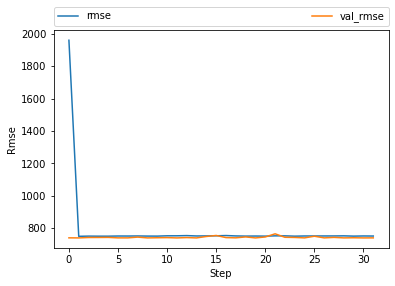

Mean Absolute Error
658.5736502617386
Root Mean Squared Error
749.8176369142396
Axis X


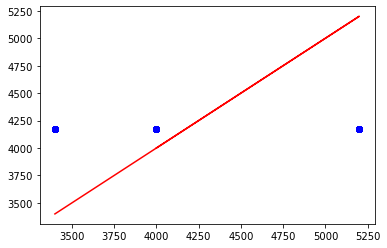

In [23]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## CNN 2

| Experiment | Test RMSE | Comments |
| --- | --- | --- |
|only using the first part of packet using slice + tuned|526|/|
| --- | --- | --- |
|using all slices + tuned|740|/|

We are now trying a more complex CNN, also described in the same article. We can see that, as CNN1, this model performs better with a 'slice' input. We also added the same GaussianNoise and BatchNormalization layers as above. Nevertheless, even after hyperparameter tuning, this model performs a little worse than CNN1.

In [52]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

steps=500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))
for i in range(3):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.MaxPooling1D((2)))
    model.add(layers.Dense(units=300))


model.add(layers.Dense(units=750))

model.add(layers.Flatten())          
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.mse,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/500
438/438 [==============================] - 8s 19ms/step - loss: 1474277.0000 - root_mean_squared_error: 1214.1981 - val_loss: 593778.8750 - val_root_mean_squared_error: 770.5705
Epoch 2/500
438/438 [==============================] - 3s 6ms/step - loss: 619309.0000 - root_mean_squared_error: 786.9619 - val_loss: 886365.1875 - val_root_mean_squared_error: 941.4697
Epoch 3/500
438/438 [==============================] - 3s 6ms/step - loss: 600845.8750 - root_mean_squared_error: 775.1425 - val_loss: 557594.6875 - val_root_mean_squared_error: 746.7227
Epoch 4/500
438/438 [==============================] - 3s 6ms/step - loss: 602655.5000 - root_mean_squared_error: 776.3089 - val_loss: 569770.8125 - val_root_mean_squared_error: 754.8317
Epoch 5/500
438/438 [==============================] - 2s 6ms/step - loss: 601162.3125 - root_mean_squared_error: 775.3466 - val_loss: 749879.9375 - val_root_mean_squared_error: 865.9561
Epoch 6/500
438/438 [==============================] - 2s 6ms/

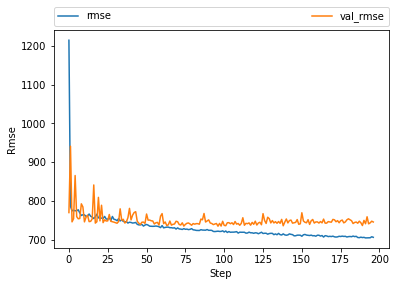

Mean Absolute Error
632.2495302242658
Root Mean Squared Error
740.630116857008
Axis X


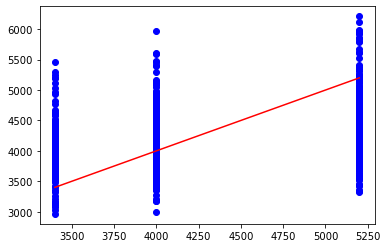

In [53]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
    patience=100)
tuner_rs = RandomSearch(
            build_model,
    objective='val_accuracy',
            seed=42,
            max_trials=20,
            executions_per_trial=2,
            overwrite=True)

tuner_rs.search_space_summary()



tuner_rs.search(X_train, y_train, epochs=300, validation_split=0.2, verbose=1, callbacks=[callback])

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

## Conv RNN

Let's now try out the third model described in the article, which is a Convolutional Recurrent Network. As for the previous models, the slice input works better. We also added the GaussianNoise and BatchNormalization layers. Nevertheless, even after tuning, this model performs a little worse than CNN1.

| Experiment | Test RMSE | Comments |
| --- | --- | --- |
|only using the first part of packet using slice + tuned|691|/|
| --- | --- | --- |
|using all slices + tuned|754|/|

In [16]:
X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

steps=500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)


model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))
for i in range(2):
    model.add(layers.Conv1D(filters=430, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))


model.add(layers.SimpleRNN(units=400,activation="relu"))

model.add(layers.Dense(units=250))
model.add(layers.Dense(units=350))

model.add(layers.Flatten())          
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.mse,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Il y a 29403 échantillons
(29403, 200, 2)
(29403,)
(array([3400, 4000, 5200]), array([6156, 6156, 6156]))
Epoch 1/500
438/438 [==============================] - 24s 55ms/step - loss: 20021978.0000 - root_mean_squared_error: 4474.5923 - val_loss: 12119216.0000 - val_root_mean_squared_error: 3481.2664
Epoch 2/500
438/438 [==============================] - 19s 42ms/step - loss: 1249625.2500 - root_mean_squared_error: 1117.8663 - val_loss: 4278831.5000 - val_root_mean_squared_error: 2068.5337
Epoch 3/500
438/438 [==============================] - 17s 40ms/step - loss: 1055582.1250 - root_mean_squared_error: 1027.4153 - val_loss: 2124848.7500 - val_root_mean_squared_error: 1457.6860
Epoch 4/500
438/438 [==============================] - 18s 41ms/step - loss: 679330.5000 - root_mean_squared_error: 824.2151 - val_loss: 1302809.8750 - val_root_mean_squared_error: 1141.4070
Epoch 5/500
438/438 [==============================] - 18s 41ms/step - loss: 643832.3750 - root_mean_squared_error: 802.39

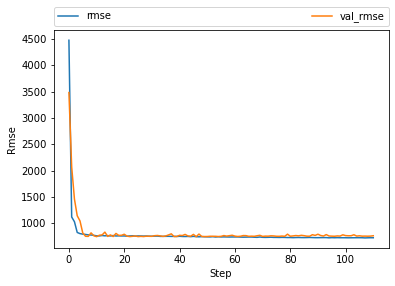

Mean Absolute Error
674.8622173150294
Root Mean Squared Error
754.0218429356031
Axis X


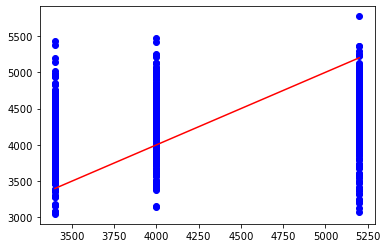

In [17]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## ResNet 1D

We now try another model described in "Fingerprinting Unmanned Aerial Vehicles withNon-standard Transmitter Waveforms". It is inspired by the ResNet architecture. We tested it directly on the slices input, using a GaussianNoise and BtachNormalization layers. We kept only the blocks up to 128 filters, otherwise the tensors became quickly too big.

| Experiment | Test RMSE | Comments |
| --- | --- | --- |
|only using the first part of packet using slice + tuned|455|/|
| --- | --- | --- |
|using all slices + tuned|671|/|

In [18]:
def proj_block(x: tf.Tensor, filters):
    y_first = layers.Conv1D(kernel_size=1,
               filters=filters,
               padding="same", activation='relu')(x)
    y_first = layers.Conv1D(kernel_size=3,
               filters=filters,
               activation='relu')(y_first)
    y_first = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               activation='relu')(y_first)
    
    y_second = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               padding="same", activation='relu')(x)
    
    y = layers.concatenate([y_first,  y_second], axis=1)
    y = layers.Activation(activation='relu')(y)

    return y

In [19]:
def id_block(x: tf.Tensor, filters):
    y_first = layers.Conv1D(kernel_size=1,
               filters=filters,
               padding="same", activation='relu')(x)
    y_first = layers.Conv1D(kernel_size=3,
               filters=filters,
               activation='relu')(y_first)
    y_first = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               activation='relu')(y_first)
    
    y = layers.concatenate([y_first,  x], axis=1)
    y = layers.Activation(activation='relu')(y)

    return y

In [28]:
X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

Il y a 29403 échantillons
(29403, 200, 2)
(29403,)
(array([3400, 4000, 5200]), array([6156, 6156, 6156]))


In [29]:

steps=500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50)

inputs = layers.Input(shape=input_shape)

t=layers.BatchNormalization()(inputs)
t=layers.GaussianNoise(0.1)(t)
t=layers.Conv1D(kernel_size=7,
               filters=64,
               activation='relu')(t)
t=layers.MaxPool1D(2)(t)
t=proj_block(t,64)
for i in range(2):
    t=id_block(t,64)

t=proj_block(t,128)
for j in range(3):
    t=id_block(t,128)

t=layers.AveragePooling1D(2)(t)
t=layers.Flatten()(t)
outputs=layers.Dense(1,activation='linear')(t)

model = tf.keras.models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.mse,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/500
438/438 [==============================] - 83s 189ms/step - loss: 1097782.8750 - root_mean_squared_error: 1047.7513 - val_loss: 560617.9375 - val_root_mean_squared_error: 748.7443
Epoch 2/500
438/438 [==============================] - 83s 189ms/step - loss: 598683.5000 - root_mean_squared_error: 773.7464 - val_loss: 637001.6875 - val_root_mean_squared_error: 798.1238
Epoch 3/500
438/438 [==============================] - 83s 190ms/step - loss: 598883.9375 - root_mean_squared_error: 773.8760 - val_loss: 559676.0625 - val_root_mean_squared_error: 748.1150
Epoch 4/500
438/438 [==============================] - 85s 194ms/step - loss: 579372.4375 - root_mean_squared_error: 761.1652 - val_loss: 575320.4375 - val_root_mean_squared_error: 758.4988
Epoch 5/500
438/438 [==============================] - 86s 195ms/step - loss: 570572.9375 - root_mean_squared_error: 755.3628 - val_loss: 557625.0000 - val_root_mean_squared_error: 746.7429
Epoch 6/500
438/438 [===========================

KeyboardInterrupt: 

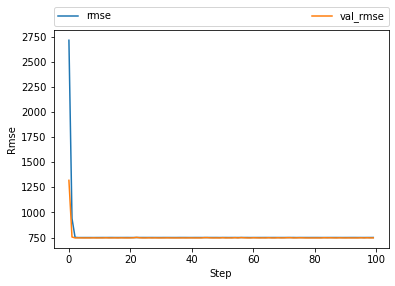

Mean Absolute Error
557.8822193321306
Root Mean Squared Error
671.6585202879927
Axis X


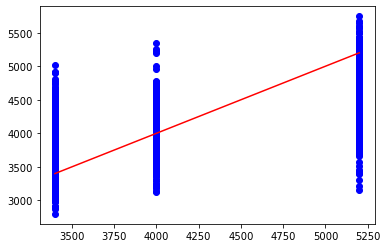

In [30]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## CNN with Conv2D

Until this point, all our CNN were composed solely of Conv1D layers, which means that they would perform a convolution on each channel (real or imaginary data from IQ data) independently. Let's now try a model using Conv2D, which will also take into account the dependency between these two channels. We are using a model described in "Trust in 5G Open RANs through Machine Learning:RF Fingerprinting on the POWDER PAWR Platform". It performs a little worse than CNN1.

| Experiment | Test RMSE | Comments |
| --- | --- | --- |
|only using the first part of packet using slice + tuned|747|/|
| --- | --- | --- |
|using all slices + tuned|745|/|

In [24]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

X_train=X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2],1))
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2],1))

input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])

steps=500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))

model.add(layers.Conv2D(filters=110, kernel_size=(5,1), padding='valid',activation='tanh'))
model.add(layers.MaxPooling2D((2,1)))
model.add(layers.Conv2D(filters=150, kernel_size=(6,1), padding='valid',activation='relu'))
model.add(layers.MaxPooling2D((2,1)))
model.add(layers.Conv2D(filters=40, kernel_size=(9,2), padding='valid',activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Dense(units=280, activation='relu'))
model.add(layers.Dense(units=480, activation='tanh'))

model.add(layers.Flatten())          
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.mse,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/500
438/438 [==============================] - 14s 32ms/step - loss: 7380658.0000 - root_mean_squared_error: 2716.7366 - val_loss: 1743220.0000 - val_root_mean_squared_error: 1320.3105
Epoch 2/500
438/438 [==============================] - 3s 6ms/step - loss: 883354.6875 - root_mean_squared_error: 939.8695 - val_loss: 570428.6250 - val_root_mean_squared_error: 755.2673
Epoch 3/500
438/438 [==============================] - 3s 6ms/step - loss: 565348.3125 - root_mean_squared_error: 751.8965 - val_loss: 557015.1250 - val_root_mean_squared_error: 746.3345
Epoch 4/500
438/438 [==============================] - 2s 5ms/step - loss: 562339.8125 - root_mean_squared_error: 749.8932 - val_loss: 558109.5625 - val_root_mean_squared_error: 747.0674
Epoch 5/500
438/438 [==============================] - 3s 6ms/step - loss: 562475.1250 - root_mean_squared_error: 749.9834 - val_loss: 557240.4375 - val_root_mean_squared_error: 746.4854
Epoch 6/500
438/438 [==============================] - 3s 6

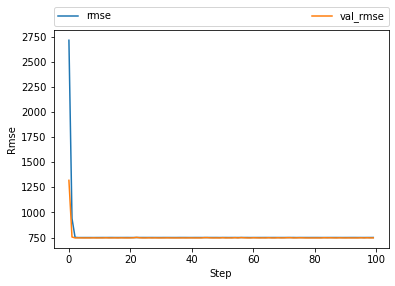

Mean Absolute Error
667.4654591905793
Root Mean Squared Error
745.2135120203656
Axis X


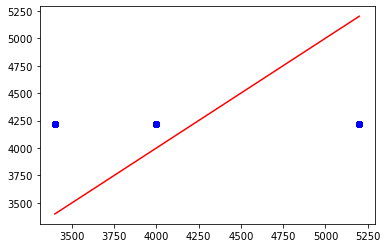

In [25]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## CNN1 + Autoencoder

We will now use the best out of our tuned Networks (CNN1) and try to apply an autoencoder on its input. An autoencoder is a neural network that can be used for feature extraction: it reduces the dimensions of an input while keeping all informations, making it easier for the following classifier to learn. We are using the autoencoder on slices of 200 samples with a 50 samples shift, as before, which gave us the best results. The autoencoder transforms this input in a smaller vector of bottleneckx1 samples instead of 200x2.

| Experiment | Test RMSE | Comments |
| --- | --- | --- |
|only using the first part of packet using slice + tuned|766|/|

In [26]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

X_train=X_train.reshape((547,2,200))
X_test=X_test.reshape((137,2,200))
input_shape=(2,200)
# define encoder
n_inputs=200
visible = layers.Input(shape=(input_shape))
# encoder level 1
e = layers.Dense(n_inputs*2)(visible)
e = layers.BatchNormalization()(e)
e = layers.LeakyReLU()(e)
# encoder level 2
e = layers.Dense(n_inputs)(e)
e = layers.BatchNormalization()(e)
e = layers.LeakyReLU()(e)
# bottleneck
n_bottleneck = 100
bottleneck = layers.Dense(n_bottleneck)(e)
# define decoder, level 1
d = layers.Dense(n_inputs)(bottleneck)
d = layers.BatchNormalization()(d)
d = layers.LeakyReLU()(d)
# decoder level 2
d = layers.Dense(n_inputs*2)(d)
d = layers.BatchNormalization()(d)
d = layers.LeakyReLU()(d)
# output layer
output = layers.Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = tf.keras.models.Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = tf.keras.models.Model(inputs=visible, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

ValueError: cannot reshape array of size 5909600 into shape (547,2,200)

In [ ]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

# load the model from file
encoder = load_model('encoder.h5', compile=False)
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)



X_train_encode=X_train_encode.reshape((X_train_encode.shape[0],X_train_encode.shape[2],2))
X_test_encode=X_test_encode.reshape((X_test_encode.shape[0],X_test_encode.shape[2],2))

input_shape_cnn=(n_bottleneck,2)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape_cnn))
model.add(layers.GaussianNoise(0.1))

for i in range(3):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.Conv1D(filters=120, kernel_size=(8), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=200))

model.add(layers.Dense(units=800))


model.add(layers.Flatten())
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.mse,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history=model.fit(X_train_encode, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


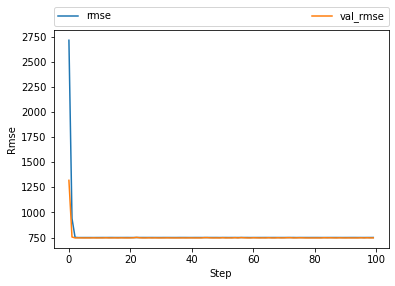

NameError: name 'X_test_encode' is not defined

In [27]:
plot_accuracy(history)
test_metrics(model, y_test, X_test_encode)

This new approach does not seem to perform better at all, it even makes the model overfit a lot more.